# TP 3 : Inversion Bayésienne pour l'étude du fonctionnement du lit de la rivière

__2 séances__

Dans ce TP on va mener une inversion du modèle de transfert de chaleur en milieu poreux en régime permanent à partir d'une simulation de référence échantillonnée en 4 points. Le transfert de chaleur a lieu dans une portion de zone hyporhéique mono-dimensionnelle de hauteur 1m représentée par 100 cellules. La différence de charge entre le haut et le bas de la colonne est fixée à 5cm.

L'inversion portera sur les trois paramètres incertains de ce modèle, à savoir :

- la perméabilité $K$
- la conductivité thermique du solide $\lambda_s$
- la porosité $n$

On va considérer (loi a priori) que ces variables sont indépendantes de lois respectives :

- $-\log_{10} K \sim \mathcal{U}(3,10)$
- $\lambda_s \sim \mathcal{U}(1,5)$
- $n \sim \mathcal{U}(0.01,0.25)$

Les points de mesure sont disposés le long de la colonne aux positions 20 cm, 40 cm, 60 cm et 80 cm.

## 1. Simulation de référence et échantillonnage
### 1.1 Simulation de référence
On choisit (on pourrait aussi les générer aléatoirement) des valeurs de référence pour les trois paramètres, compatibles avec la loi a priori.


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Caracteristics of the soil column:
	depth 1.0 m
	depth 1.0 m
	 100 cells of side size 0.01 m
	Hydraulic Properties of porous media Unknown
		permeability or hydraulic conductivity: 8.000e-04 m s-1
		porosity: 1.500e-01 --
	Thermal Properties of the phase (pure solid) Soil Column
		thermal conductivity:: 2.000e+00 W m-1 K-1
		specific heat capacity:: 9.570e+02 m2 s-2 K-1
		density:: 2.600e+03 kg m-3
	equivalent parameters of  Soil Column :
		equivalent thermal conductivity: : 1.737e+00 W m-1 K-1
		equivalent heat capacity: : 2.743e+06 W m-1 K-1
	effective parameters of Soil Column:
		effective thermal conductivity: 4.151e-07 m2 s-1
		effective advective parameter: 1.221e-03 m s-1
Running pyHeat in steady state with the following specs:
	Hydraulic Boundary Conditions:
		differential pressure head (top - bottom) = 0.05 m
	Temperature Boundary Condi

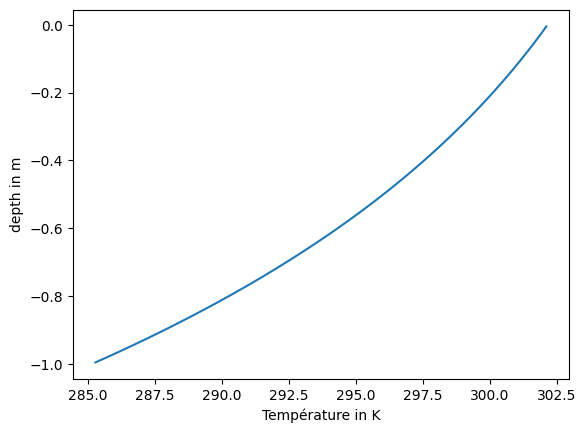

In [8]:
%pylab inline

from codepyheat.geometry import Column
from codepyheat import JSONPATH

moinslog10K_ref=5
K_ref = 1e-5
lambda_s_ref = 2
n_ref = 0.1

# step 1
dico = {
    "depth": {
            "val": "1",
            "unit": "m"
        },
    "ncells": 100
}

rivBed = Column(dico)
rivBed.printProps()

# step 2
rivBed.setHomogeneousPorMed(JSONPATH + "paramColumn.json")
rivBed.physProp.printProps()

# step 3
rivBed.setBcHyd(JSONPATH + "configBcHydro.json")
rivBed.setBcT(JSONPATH + "configBcTemp.json")

# step 4 running forward model with other parameter values
ref = rivBed.runForwardModelSteadyState(K_ref, lambda_s_ref, n_ref)


### 1.2 Echantillonnage

Extraire les valeurs de température aux points de mesure et les *perturber* en y additionnant une gaussienne centrée de variance $\sigma^2 = 1$, correspondant à l'erreur de mesure.
        

In [9]:
import numpy as np 

def temp(depth):
    n,h=int(dico["ncells"]),int(dico["depth"]["val"])
    return ref[ int(n*depth/h) ]

echant=[0.2,0.4,0.6,0.8]

def get_temp_echant(echant, brouillee = True):
    tempe=[]
    for val in echant : 
        tempe.append( float(temp(val)))
    tempe_brouille=[]
    for val in echant : 
        tempe_brouille.append( float(temp(val)) + np.random.normal(0,1) )
    if brouillee:
        return tempe_brouille
    else:
        return tempe   

print(get_temp_echant(echant))
print(get_temp_echant(echant, brouillee=False))

[299.6539385162764, 296.58648045637653, 292.74322832308894, 288.8902747794557]
[300.0537584236561, 297.47372385027586, 294.2278220179066, 290.14420282377324]


## 2. Préliminaires

On va implémenter un algorithme MCMC de type marche aléatoire à incréments symétriques (SIMH) avec une loi propositionnelle gaussienne.

### 2.1 Lois a priori

Les lois a priori considérées sont toutes uniformes. Elles sont donc caractérisées par leur intervalle de variation.

In [10]:
range_moinslog10K = [3,10]
range_lambda_s = [1,5]
range_n = [.01,.25]


### 2.2 Paramétrisation

Choix des valeurs des écarts types de la marche aléatoire pour chacun des paramètres et l'erreur de mesure. Les valeurs suivantes sont proposées en première intention, on pourra les modifier si besoin.

In [11]:
sigma_moinslog10K = 1
sigma_lambda_s = .5
sigma_n = .06

sigma_obs = 1

### 2.3 Noyau propositionnel

Ecrire une fonction qui perturbe l'état courant d'un paramètre tout en respectant le prior (notamment ses bornes).

In [12]:
import numpy as np
def perturbation(param, sigma, range): 
    result = param + np.random.normal(0, sigma)
    if result < range[0] or result > range[1]:
        reste = result%abs(range[1]-range[0])
        result = range[0] + reste
    return result

### 2.4 Modèle direct

Ecrire une fonction qui renvoie une liste contenant les valeurs du modèle direct aux points de données ainsi que le profil de température complet.

In [13]:
Dict_Param = {
    "moinslog10K": moinslog10K_ref,
    "lambda_s": lambda_s_ref,
    "n": n_ref
}

def modele_directe (Dict_Param, brouillee = True):
    ref = rivBed.runForwardModelSteadyState(10**(-Dict_Param["moinslog10K"]), Dict_Param["lambda_s"], Dict_Param["n"], draw=False, verbose=False)
    t_echant = get_temp_echant(echant, brouillee=brouillee)
    return ref, t_echant

ref, t_echant_brouille = modele_directe(Dict_Param)

Ecrire une fonction qui calcule l'énergie du système. On rappelle que cette quantité va nous servir à visualiser l'entrée de la chaîne en régime stationnaire.

In [14]:
def energie_systeme(tempe_modele, tempe_obs, sigma_obs):
    """
    Calcule l'énergie du système pour le MCMC.
    tempe_modele : liste des températures simulées aux points de mesure
    tempe_obs : liste des températures observées (bruitées)
    sigma_obs : écart-type de l'erreur de mesure
    """
    tempe_modele = np.array(tempe_modele)
    tempe_obs = np.array(tempe_obs)
    return np.sum((tempe_modele - tempe_obs)**2) / (2 * sigma_obs**2)

temp_obs=t_echant_brouille
sigma_obs=1

### 2.5 Initialisation

Initialiser la chaîne en générant une valeur de chacun des paramètres selon le prior, appliquer le modèle direct et calculer l'énergie.

In [15]:
import numpy as np

# Tirage initial selon le prior
moinslog10K = np.random.uniform(*range_moinslog10K)
lambda_s = np.random.uniform(*range_lambda_s)
n = np.random.uniform(*range_n)


Dict_Param["moinslog10K"] = moinslog10K
Dict_Param["lambda_s"] = lambda_s
Dict_Param["n"] = n

tempe_obs=get_temp_echant(echant)
profil, tempe_modele = modele_directe(Dict_Param)
E = energie_systeme(tempe_modele, tempe_obs, sigma_obs)


Choisir le nombre d'itérations et initialiser les tableaux qui contiendront :
 
 - les valeurs des paramètres
 - l'énergie des états générés
 - la moyenne des taux d'acceptation
 - les profils de température

In [16]:
# Initialisation
N = 5000  # nombre d'itérations
params = np.zeros((N, 3))
energies = np.zeros(N)
accepts = np.zeros(N)
profils = []

sigma_obs = 1
params[0] = [moinslog10K, lambda_s, n]
energies[0] = E
profils.append(profil)
accepts[0] = 1

## 3. MCMC

### 3.1 Variance d'erreur de mesure connue

Dans un premier temps, on suppose la variance de l'erreur d'estimation connue, implémenter l'agorithme MCMC d'inversion

In [17]:
for i in range(1, N):
    # Propositions

    moinslog10K_prop = perturbation(moinslog10K, sigma_moinslog10K, range_moinslog10K)
    lambda_s_prop = perturbation(lambda_s, sigma_lambda_s, range_lambda_s)
    n_prop = perturbation(n, sigma_n, range_n)

    Dict_Param["moinslog10K"] = moinslog10K_prop
    Dict_Param["lambda_s"] = lambda_s_prop
    Dict_Param["n"] = n_prop
    profil_prop,tempe_modele_prop = modele_directe(Dict_Param)
    E_prop = energie_systeme(tempe_modele_prop, tempe_obs, sigma_obs)

    # Calcul du ratio d'acceptation
    #Par symétrie de la fonction q, la proba d'acceptation ne dépend que de pi
    alpha = np.exp(E - E_prop) #probabilité d'acceptation, déterminée uniquement par la loi gaussienne propositionnelle 
    if np.random.rand() < alpha: 
        # Acceptation
        moinslog10K, lambda_s, n = moinslog10K_prop, lambda_s_prop, n_prop
        E = E_prop
        profil = profil_prop
        accepts[i] = 1
    else:
        accepts[i] = 0
    
    params[i] = [moinslog10K, lambda_s, n]
    energies[i] = E
    profils.append(profil)


Représenter graphiquement l'énergie et la probabilité d'acceptation estimée en fonction du nombre d'itérations. Commenter

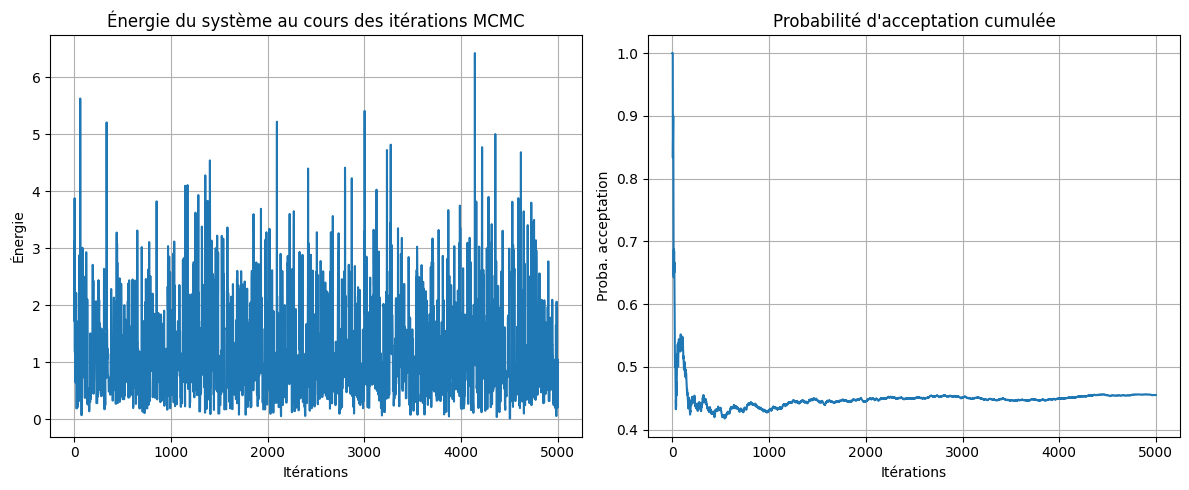

In [18]:
import numpy as np
import matplotlib.pyplot as plt

proba_accept = np.cumsum(accepts) / np.arange(1, N + 1) # probabilité d'acceptation cumulée grace à np.cumsum

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(energies)
plt.xlabel('Itérations')
plt.ylabel('Énergie')
plt.title('Énergie du système au cours des itérations MCMC')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(proba_accept)
plt.xlabel('Itérations')
plt.ylabel('Proba. acceptation')
plt.title('Probabilité d\'acceptation cumulée')
plt.grid()

plt.tight_layout()
plt.show()


A partir des échantillons générés, représenter les histogrammes a posteriori des trois paramètres. Commenter

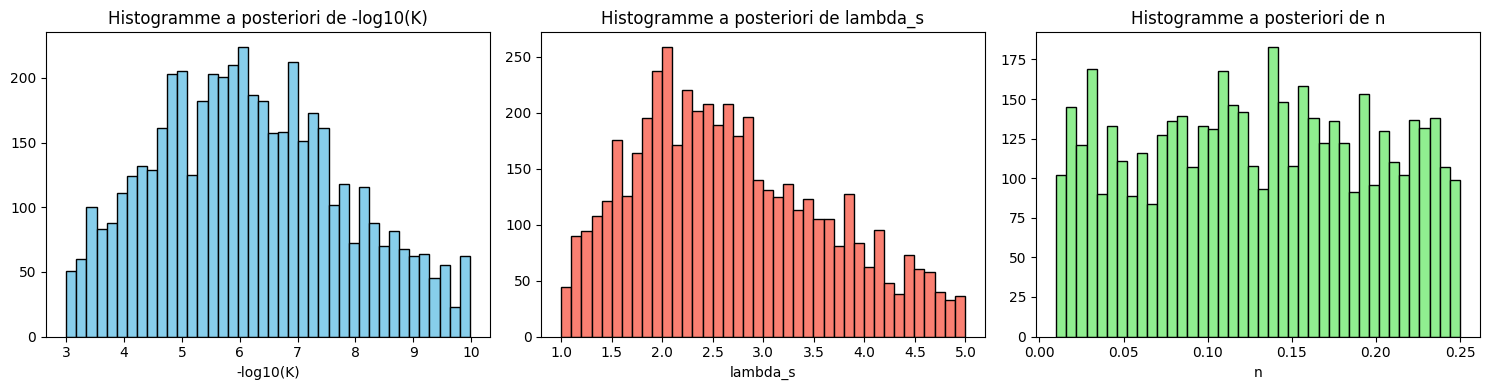

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(params[:,0], bins=40, color='skyblue', edgecolor='black')
plt.xlabel('-log10(K)')
plt.title('Histogramme a posteriori de -log10(K)')

plt.subplot(1, 3, 2)
plt.hist(params[:,1], bins=40, color='salmon', edgecolor='black')
plt.xlabel('lambda_s')
plt.title('Histogramme a posteriori de lambda_s')

plt.subplot(1, 3, 3)
plt.hist(params[:,2], bins=40, color='lightgreen', edgecolor='black')
plt.xlabel('n')
plt.title('Histogramme a posteriori de n')

plt.tight_layout()
plt.show()

Représenter maintenant les couples d'histogrammes bivariés à l'aide de la fonction `plt.hist2d`. Commenter

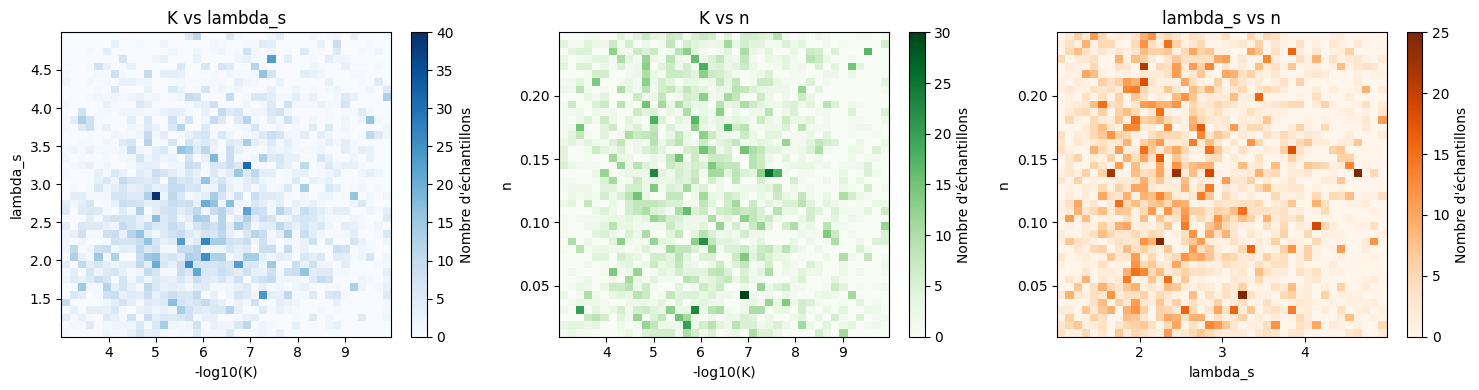

In [20]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist2d(params[:,0], params[:,1], bins=40, cmap='Blues')
plt.xlabel('-log10(K)')
plt.ylabel('lambda_s')
plt.title('K vs lambda_s')
plt.colorbar(label='Nombre d\'échantillons')

plt.subplot(1, 3, 2)
plt.hist2d(params[:,0], params[:,2], bins=40, cmap='Greens')
plt.xlabel('-log10(K)')
plt.ylabel('n')
plt.title('K vs n')
plt.colorbar(label='Nombre d\'échantillons')

plt.subplot(1, 3, 3)
plt.hist2d(params[:,1], params[:,2], bins=40, cmap='Oranges')
plt.xlabel('lambda_s')
plt.ylabel('n')
plt.title('lambda_s vs n')
plt.colorbar(label='Nombre d\'échantillons')

plt.tight_layout()
plt.show()

Représenter le profil de température médian ainsi que les quantiles (cellule par cellule) à 2.5% et 97.5%. Comparer avec le profil de référence et les données bruitées.

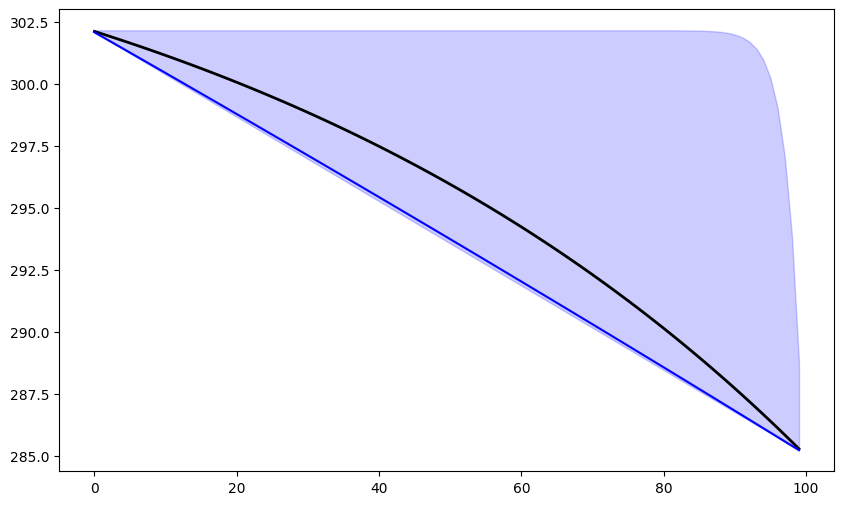

In [24]:
import numpy as np
import matplotlib.pyplot as plt

profils_array = np.array(profils)  # (N, ncells)
median = np.median(profils_array, axis=0)
q025 = np.quantile(profils_array, 0.025, axis=0)
q975 = np.quantile(profils_array, 0.975, axis=0)

plt.figure(figsize=(10,6))
plt.plot(ref, label='Profil de référence', color='black', linewidth=2)
plt.plot(median, label='Médiane a posteriori', color='blue')
plt.fill_between(np.arange(len(median)), q025, q975, color='blue', alpha=0.2, label='Quantiles 2.5% - 97.5%')

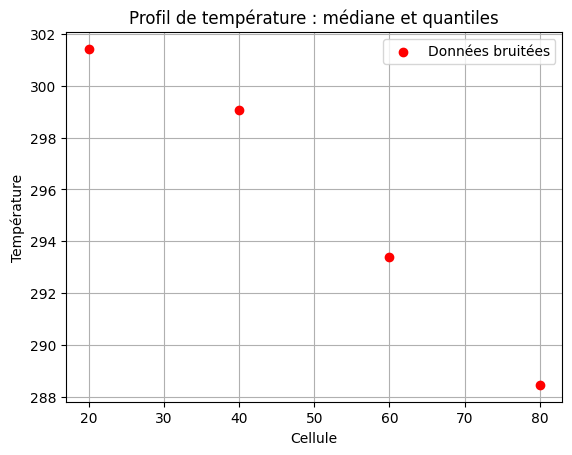

In [23]:
plt.scatter([int(100*x) for x in echant], t_echant_brouille, color='red', label='Données bruitées', zorder=10)

plt.xlabel('Cellule')
plt.ylabel('Température')
plt.title('Profil de température : médiane et quantiles')
plt.legend()
plt.grid()
plt.show()

### 3.2 Estimation de la variance d'erreur de mesure (facultatif)

On suppose désormais que $\sigma_{OBS} \sim \mathcal{U}_{[0.25,2]}$. Implémenter un algorithme MCMC qui réalise également l'inférence bayésienne sur ce paramètre. Reprendre les questions précédentes avec ces nouveaux résultats. Commenter

## 4. Etude du fonctionnement du lit de la rivière en régime permanent

Dans cette partie, on étudie les écoulements dans le lit de la rivière suivant :
+ différents forçages hydrauliques 
+ différents forçages thermiques 
+ différents champs de paramètres. 

Au moins trois situations hydrodynamiques et thermiques seront considérées.

### 4.1. Ecoulement hivernal de la rivière vers la nappe

On suppose une pression différentielle de 10 cm entre la rivière et la nappe. 

La température de l'eau de rivière est de 2$^{\circ} C$, alors que celle des eaux souterraines est de 16$^{\circ} C$.

Résolvez le transport de chaleur dans cette configuration en balayant des valeurs de paramètres appropriées. A cet effet, on considère que la première partie du TP a permis de caractériser les distributions statistiques des trois paramètres que sont la perméabilité, la conductivité thermique, et la porosité, et de manière optionnelle l'erreur de mesure.

Discutez les résultats.



Tout d'abord, on écrit une fonction pour lancer plusieurs simulations en steady state et une fonction d'affichage des résultats

Ensuite, on fixe les conditions limites, puis on effectue ensuite une série de simulations dont on trace le résultat


### 4.2. Ecoulement estival de la nappe vers la rivière

On suppose une pression différentielle de -5 cm cm entre la rivière et la nappe. 

La température de l'eau de rivière est de 28$^{\circ} C$, alors que celle des eaux souterraines de 14$^{\circ} C$.

Résolvez le transport de chaleur dans cette configuration en balayant des valeurs de paramètres appropriées. A cet effet, on considère que la première partie du TP a permis de caractériser les distributions statistiques des trois paramètres que sont la perméabilité, la conductivité thermique, et la porosité, et de manière optionnelle l'erreur de mesure.

Discutez les résultats.



### 4.3. Configuration d'intérêt pour vous

Réalisez le même travail pour une situation d'intérêt selon vous. Justifier votre choix puis résolvez le problème.